# Data Preparation 

Data is processed for models that determine the usefullness of spiral galaxies for the task of inclination measurements by leveraging the classification methodologies. 

We are dealing with binary labels, where `0` denotes accpeted galaxies, and `1` represent rejected images due to various anolmalies, and ambiguities, or having poor quality. A few face-on galaxies (those with inclination lower than 45 degrees from face-on) has also been rejected. 


## Augmentation

To prepare data for the full analysis, we increase the resolution of the input images to 128x128. Each images can be rotated arbitrarily, with some additional noise and other tweaks.

Note that the aspect ratio of images should not be changed to preserve the elliptical shape of the projected galaxies, and thus their inclinations.

In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random
from datetime import datetime
import json
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
from sklearn.model_selection import train_test_split
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa

In [2]:
data = np.load('data_128x128_g_originals.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
data.close() 
del data

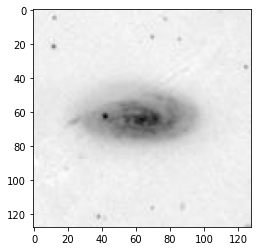

In [3]:
plt.imshow(images_[0])

In [4]:
ia.seed(100)

seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3), per_channel=0.5),
    iaa.Add((-5, 5), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.5),
    iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.50, iaa.Grayscale(alpha=1.)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(0, 255))
    ], random_order=True)


seqGray = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(255, 255))
    ], random_order=True)

In [5]:
def esn_shuffle(array, seed=None):
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(array)
        return array

In [34]:
def train_test_replication(npzFile, outFileRoot, pgcIDs_test):
       
    data = np.load(npzFile)
    images_ = data['images'].astype(np.uint8)
    labels_ = data['labels'] 
    data.close() 
    del data
    
    images_c = images_
    labels_c = labels_[1,:]
    pgcIDs_c = labels_[0,:]
    
    labels_c[(labels_c < 10)] = 1  # reject
    labels_c[(labels_c > 10)] = 0  # accept
    
    idx = np.isin(pgcIDs_c, pgcIDs_test)
    npzTest = outFileRoot+'test_000.npz'
    np.savez_compressed(npzTest, 
                        images=images_c[idx], 
                        labels=labels_c[idx], 
                        pgcIDs=pgcIDs_c[idx])  
    print('created ...', npzTest)
    
    
    idx = np.logical_not(np.isin(pgcIDs_c, pgcIDs_test))
    npzTrain = outFileRoot+'train_000.npz'
    np.savez_compressed(npzTrain, 
                        images=images_c[idx], 
                        labels=labels_c[idx], 
                        pgcIDs=pgcIDs_c[idx])  
    print('created ...', npzTrain)
    
    
        
    del images_
    del labels_

    del images_c
    del labels_c
    del pgcIDs_c    

In [35]:
def train_test_creation(npzFile, outFileRoot, m_iter=3):
    
    data = np.load(npzFile)
    images_ = data['images'].astype(np.uint8)
    labels_ = data['labels'] 
    data.close() 
    del data
    
    images_c = images_
    labels_c = labels_[1,:]
    pgcIDs_c = labels_[0,:]
    
    labels_c[(labels_c < 10)] = 1  # reject
    labels_c[(labels_c > 10)] = 0  # accept

    N = images_c.shape[0]
    idx = np.arange(N)
    idx = esn_shuffle(idx, seed=0)
    images_c = images_c[idx]
    labels_c = labels_c[idx]
    pgcIDs_c = pgcIDs_c[idx]

    images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, 
                                                                                                        labels_c, 
                                                                                                        pgcIDs_c, 
                                                                                                        test_size=0.15,
                                                                                                        random_state=100
                                                                                                       )
    npzTest = outFileRoot+'test_000.npz'
    np.savez_compressed(npzTest, 
                        images=images_test, 
                        labels=labels_test, 
                        pgcIDs=pgcIDs_test)
    
    print('created ...', npzTest)
    
    
    npzTrain = outFileRoot+'train_000.npz'
    np.savez_compressed(npzTrain, 
                        images=images_train, 
                        labels=labels_train, 
                        pgcIDs=pgcIDs_train)
    
    print('created ...', npzTrain)


        
    return pgcIDs_test

In [36]:
# band = 'r'
# pgcIDs_test = train_test_creation('./data_128x128_'+band+'_originals.npz', 
#                                                      'samples_binary/'+band+'_128x128_')

# for band in ['RGB', 'g', 'i']:
#     train_test_replication('./data_128x128_'+band+'_originals.npz', 
#                            'samples_binary/'+band+'_128x128_', 
#                            pgcIDs_test)

created ... samples_binary/r_128x128_test_000.npz
created ... samples_binary/r_128x128_train_000.npz
created ... samples_binary/RGB_128x128_test_000.npz
created ... samples_binary/RGB_128x128_train_000.npz
created ... samples_binary/g_128x128_test_000.npz
created ... samples_binary/g_128x128_train_000.npz
created ... samples_binary/i_128x128_test_000.npz
created ... samples_binary/i_128x128_train_000.npz


In [40]:
data = np.load('./samples_binary/i_128x128_train_000.npz')
images = data['images'].astype(np.uint8)
labels = data['labels'] 
pgcIDs = data['pgcIDs']
del data

In [41]:
n = len(labels)

len(labels[(labels==0)]) , len(labels[(labels==1)])

(12637, 4274)

In [42]:
pgcIDs

array([  32706,  214284,   34733, ...,   15047, 5059089,   68793],
      dtype=int32)

### Run this part separately .....

In [43]:
%%time 

data = np.load('samples_binary/RGB_128x128_train_000.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
pgcIDs_RGB = data['pgcIDs']
N = images_RGB.shape[0]
filter_RGB = np.chararray(N)
filter_RGB[:] = 'c'
data.close() 
del data


data = np.load('samples_binary/g_128x128_train_000.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
pgcIDs_g = data['pgcIDs']
N = images_g.shape[0]
filter_g = np.chararray(N)
filter_g[:] = 'g'
data.close() 
del data

data = np.load('samples_binary/r_128x128_train_000.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
pgcIDs_r = data['pgcIDs']
N = images_r.shape[0]
filter_r = np.chararray(N)
filter_r[:] = 'r'
data.close() 
del data

data = np.load('samples_binary/i_128x128_train_000.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
pgcIDs_i = data['pgcIDs']
N = images_i.shape[0]
filter_i = np.chararray(N)
filter_i[:] = 'i'
data.close() 
del data

CPU times: user 16.1 s, sys: 720 ms, total: 16.9 s
Wall time: 16.9 s


In [44]:
images_gri = np.concatenate((images_g, images_r, images_i))
labels_gri = np.concatenate((labels_g, labels_r, labels_i))
pgcIDs_gri = np.concatenate((pgcIDs_g, pgcIDs_r, pgcIDs_i))
filter_gri = np.concatenate((filter_g, filter_r, filter_i))

In [45]:
def augment_N(images, labels, pgcIDs, filter, N, isGray=True, seed=0):
    
    if isGray:
        images_aug = seqGray(images=images)
    else:
        images_aug = seq(images=images)
    labels_aug = labels
    pgcIDs_aug = pgcIDs
    filter_aug = filter
    
    ii = 0 
    while len(labels_aug)<N:
        if isGray:
            images_aug = np.concatenate((images_aug, seqGray(images=images)))
        else:
            images_aug = np.concatenate((images_aug, seq(images=images)))         
        labels_aug = np.concatenate((labels_aug, labels))
        pgcIDs_aug = np.concatenate((pgcIDs_aug, pgcIDs))
        filter_aug = np.concatenate((filter_aug, filter))
        
    
    indx = esn_shuffle(np.arange(len(labels_aug)), seed=seed)
    images_aug = images_aug[indx][:N]
    labels_aug = labels_aug[indx][:N]
    pgcIDs_aug = pgcIDs_aug[indx][:N]
    filter_aug = filter_aug[indx][:N]
    
    return images_aug, labels_aug, pgcIDs_aug, filter_aug

In [54]:
import copy 

def uniformer(images, labels, pgcIDs, filter, N=1000, isGray=True, seed=0):
    
    n = len(labels)
    indices = np.arange(n)
    
    for binaryLabel in [0, 1]:
        
        idx = indices[(labels==binaryLabel)]
        images_aug, labels_aug, pgcIDs_aug, filter_aug = augment_N(images[idx], 
                                                                   labels[idx], 
                                                                   pgcIDs[idx], 
                                                                   filter[idx], N, isGray=True, seed=seed)
        if binaryLabel==1:
            images_aug_ = np.concatenate((images_aug_, images_aug))
            labels_aug_ = np.concatenate((labels_aug_, labels_aug))
            pgcIDs_aug_ = np.concatenate((pgcIDs_aug_, pgcIDs_aug))
            filter_aug_ = np.concatenate((filter_aug_, filter_aug))
        else:
            images_aug_ = copy.deepcopy(images_aug)
            labels_aug_ = copy.deepcopy(labels_aug)
            pgcIDs_aug_ = copy.deepcopy(pgcIDs_aug)
            filter_aug_ = copy.deepcopy(filter_aug)

    return images_aug_, labels_aug_, pgcIDs_aug_, filter_aug_

In [62]:
for i in range(50):
    t1 =  datetime.now()

    ia.seed(2*i+12)
    
    images_aug_gri, labels_aug_gri, pgcIDs_aug_gri, filter_aug_gri = uniformer(images_gri, 
                                                                               labels_gri, 
                                                                               pgcIDs_gri, 
                                                                               filter_gri, 
                                                                               N=15000, isGray=True, seed=3*i+36)
    ia.seed(5*i+25)
    
    images_aug_RGB, labels_aug_RGB, pgcIDs_aug_RGB, filter_aug_RGB = uniformer(images_RGB, 
                                                                               labels_RGB, 
                                                                               pgcIDs_RGB, 
                                                                               filter_RGB, 
                                                                               N=5000, isGray=False, seed=3*i+41)
    N_RGB = len(labels_aug_RGB)
    N_gri = len(labels_aug_gri)

    indx = esn_shuffle(np.arange(N_gri), seed=6*i+40)
    images_aug = images_aug_gri[indx][:N_RGB]
    labels_aug = labels_aug_gri[indx][:N_RGB]
    pgcIDs_aug = pgcIDs_aug_gri[indx][:N_RGB]
    filter_aug = filter_aug_gri[indx][:N_RGB]

    n = len(images_aug)
    p = int(n/2)
    images_aug[:p] = 255 - images_aug[:p]

    ia.seed(2*i+51)
    images_aug = np.concatenate((images_aug_RGB,images_aug))
    labels_aug = np.concatenate((labels_aug_RGB,labels_aug))
    pgcIDs_aug = np.concatenate((pgcIDs_aug_RGB,pgcIDs_aug))
    filter_aug = np.concatenate((filter_aug_RGB,filter_aug))
    
    indx = np.arange(len(images_aug))
    indx = esn_shuffle(indx, seed=32*i+13)
    images_aug = images_aug[indx]
    labels_aug = labels_aug[indx]
    pgcIDs_aug = pgcIDs_aug[indx]
    filter_aug = filter_aug[indx]
    
    npzname = 'Uset0_binary_npz/128x128_train_aug_'+'%02d'%(i+1)+'.npz'
    np.savez_compressed(npzname, 
                            images=images_aug, 
                            labels=labels_aug, 
                            pgcIDs=pgcIDs_aug,
                            filter=filter_aug
                       )
    
    t2 =  datetime.now()
    print(npzname+' ... saved.')
    print("Process time: ", i+1, t2-t1)

Uset0_binary_npz/128x128_train_aug_01.npz ... saved.
Process time:  1 0:02:30.147688
Uset0_binary_npz/128x128_train_aug_02.npz ... saved.
Process time:  2 0:02:19.308046
Uset0_binary_npz/128x128_train_aug_03.npz ... saved.
Process time:  3 0:02:16.851175
Uset0_binary_npz/128x128_train_aug_04.npz ... saved.
Process time:  4 0:02:17.142847
Uset0_binary_npz/128x128_train_aug_05.npz ... saved.
Process time:  5 0:02:15.445072
Uset0_binary_npz/128x128_train_aug_06.npz ... saved.
Process time:  6 0:02:17.710284
Uset0_binary_npz/128x128_train_aug_07.npz ... saved.
Process time:  7 0:02:17.475832
Uset0_binary_npz/128x128_train_aug_08.npz ... saved.
Process time:  8 0:02:16.520965
Uset0_binary_npz/128x128_train_aug_09.npz ... saved.
Process time:  9 0:02:16.470757
Uset0_binary_npz/128x128_train_aug_10.npz ... saved.
Process time:  10 0:02:15.724158
Uset0_binary_npz/128x128_train_aug_11.npz ... saved.
Process time:  11 0:02:15.450415
Uset0_binary_npz/128x128_train_aug_12.npz ... saved.
Process ti

In [56]:
images_aug.shape, labels_aug.shape, pgcIDs_aug.shape, filter_aug.shape

((20000, 128, 128, 3), (20000,), (20000,), (20000,))

In [57]:
len(labels_aug[(labels_aug==0)]) , len(labels_aug[(labels_aug==1)])

(9955, 10045)

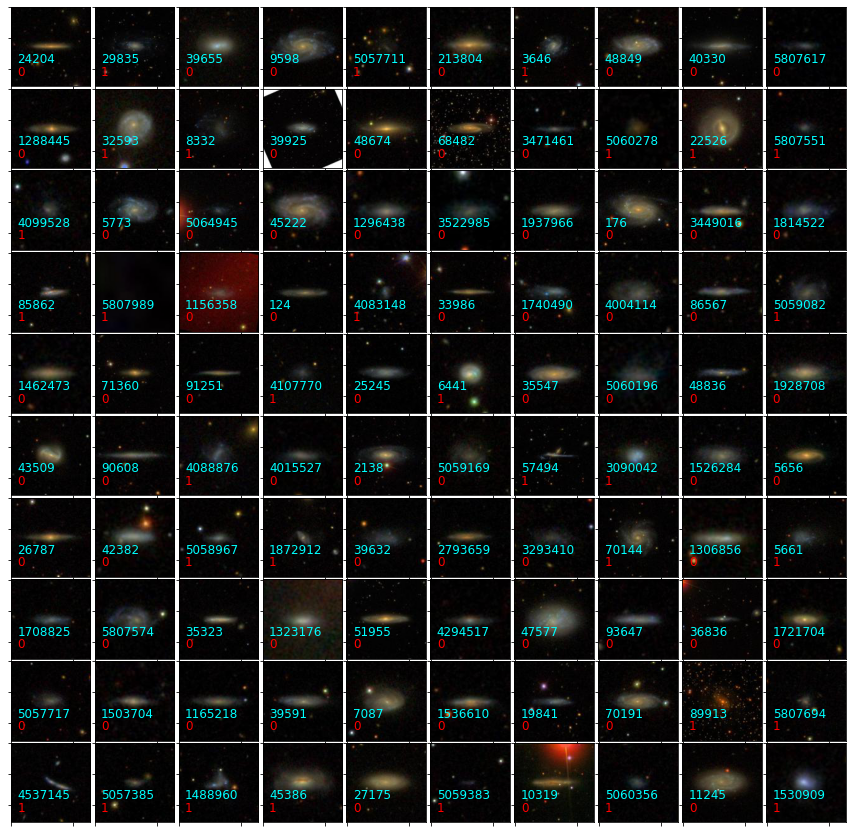

In [64]:
# data = np.load('Uset0_npz/128x128_train_aug_01.npz')
data = np.load('samples_binary/RGB_128x128_test_000.npz')
images_ = data['images'].astype(np.uint8)
labels_ = data['labels'] 
pgcIDs_ = data['pgcIDs']
# filter_  = data['filter']
data.close() 
del data


n = 10
m = 10

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
for i in range(n):
    for j in range(m):

        ax = axes[i][j]
        ax.imshow(images_[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        
        ax.text(10, 110, labels_[t], color='red', fontsize=12)
#         ax.text(10, 20, filter_[t], color='red', fontsize=12)
        ax.text(10, 90, pgcIDs_[t], color='cyan', fontsize=12)

        t+=1
  
plt.subplots_adjust(hspace=0.03, wspace=0.03)

(array([1652.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         633.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

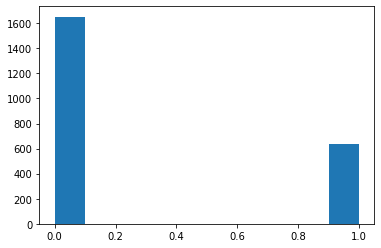

In [65]:
plt.hist(labels_)